# NREL MIDC station network

The [Measurement and Instrumentation Data Center (MIDC)](https://midcdmz.nrel.gov/) is operated by NREL and provides irradiance and meteorological data from a number of ground stations in the U.S. The stations vary in quality, with some stations measuring all three components with high-quality instruments and other stations featuring a rotating shadow band pyranometer.

The most notable station is the [Baseline Measurement System (BMS)](https://midcdmz.nrel.gov/apps/sitehome.pl?site=BMS) at NREL's [Solar Radiation Research Laboratory (SRRL)](https://www.nrel.gov/esif/solar-radiation-research-laboratory.html) outside of Denver, Colorado. The BMS features the world's largest collection of operating pyranometers and pyrheliometers. A number of sky imagers, PV reference cells, and spectral radiometers are also located at the site. Instruments at the BMS are cleaned each weekday and frequently calibrated. Due to the large collection of co-located and well maintained instruments, the BMS data is ideal for comparing different types of instruments.

Note, the MIDC includes several inactive stations. Also, several of the active stations are no longer cleaned or calibrated frequently. For these reasons, the SolarStations.Org catalog only includes the SRRL BMS, SOLARTAC, and Flatirons M2 sites, as these measures all three irradiance components and are active. See the map below for the locations of the stations.


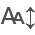

In [1]:
import pandas as pd
from itables import init_notebook_mode, show
init_notebook_mode(all_interactive=True)

stations_midc_url = 'https://midcdmz.nrel.gov/apps/data_api_doc.pl?_idtextlist_'
stations = pd.read_csv(stations_midc_url)
stations = stations.rename(columns={
    'STATION_ID': 'Station Identifier',
    'STATION_FULLNAME': 'Station name',
    'STATION_SHORTNAME': 'Station Abbreviation',
    'LATITUDE_DEG': 'Latitude',
    'LONGITUDE_DEG': 'Longitude',
    'ELEVATION_M': 'Elevation',
    'ACTIVE': 'Active'})

del stations['RESERVED']

show(stations, scrollY="500px", scrollX=True, scrollCollapse=True, paging=False, classes="display", order=[[0, "asc"]],
     showIndex=False, columnDefs=[{"className": "dt-left", "targets": "_all"}])

In [5]:
import folium
from folium import plugins
import folium_legend

EsriImagery = "https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}"
EsriAttribution = "Tiles &copy; Esri &mdash; Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community"

# Create Folium map
m = folium.Map(
    location=[35, -107],
    zoom_start=3, min_zoom=1, max_bounds=True,
    control_scale=True,  # Adds distance scale in lower left corner
    tiles='openstreetmap',
)

# Function for determining station color
def marker_color(row):
    if row['Active'] == 1:  # active station
        color = '#008000'  # green
    else:  # inactive/closed station
        color = '#ff422b'  # red
    return color

# SRRL, STAC, and UoE has multiple stations with same latitude/longitude
# append the main stations to the end, so they plot ontop
stations_to_plot = pd.concat([
    stations,
    stations[stations['Station Identifier'] == 'UOSMRL'],
    stations[stations['Station Identifier'] == 'BMS'],
    stations[stations['Station Identifier'] == 'STAC']])

# Add each station to the map
for index, row in stations_to_plot.iterrows():
    color = marker_color(row)
    folium.CircleMarker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"{row['Station name']} ({row['Station Identifier']})",
        tooltip=f"{row['Station name']} ({row['Station Identifier']})",
        radius=5, color=color,
        fill_color=color, fill=True).add_to(m)

folium.raster_layers.TileLayer(EsriImagery, name='World imagery', attr=EsriAttribution, show=False).add_to(m)
folium.LayerControl(position='topright').add_to(m)

# Additional options and plugins
plugins.Fullscreen(position='bottomright').add_to(m)  # Add full screen button to map
folium.LatLngPopup().add_to(m)  # Show latitude/longitude when clicking on the map

# Create legend
labels = ['Active', 'Inactive']
colors = ['#008000', '#ff422b']  # copied from above
legend = folium_legend.make_legend(labels, colors, title="Station status")
m.get_root().html.add_child(legend)  # Add Legend to map

# Show the map
m

## Data retrieval
Data from the MIDC can be retrieved from the MIDC website or using the [MIDC raw data API](https://midcdmz.nrel.gov/apps/data_api_doc.pl).

```{admonition} Note
If you use data from the MIDC in any publication, make sure to cite it. As an example, the citation for the BMS site is:

Andreas, A.; Stoffel, T.; (1981). NREL Solar Radiation Research Laboratory (SRRL): Baseline
Measurement System (BMS); Golden, Colorado (Data); NREL Report No. DA-5500-56488.
http://dx.doi.org/10.5439/1052221
```

Data can be downloaded and parsed conveniently using the pvlib-python iotools module using the function [`pvlib.iotools.read_midc_raw_data_from_nrel`](https://pvlib-python.readthedocs.io/en/stable/reference/generated/pvlib.iotools.read_midc_raw_data_from_nrel.html). If you use pvlib iotools for published work, please Jensen et al. (2023) which provides additional background information. The use of the function is shown below, demonstrating how to retrieve five days of data:

In [3]:
import pvlib

data = pvlib.iotools.read_midc_raw_data_from_nrel(
    site='BMS',  # station identifier
    start=pd.Timestamp(2020,6,1),
    end=pd.Timestamp(2020,6,5))

# show a subset of the data
show(data.iloc[:5, 5:10], dom="tpr")

C:\Users\arajen\Anaconda3\envs\solarstations\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


<br>

The retrieved BMS dataset contains numerous instruments measuring the same irradiance component. Let's, for example, compare the global horizontal irradiance (GHI) measured by a high-quality CMP22 pyranometer with that of a low-cost CM3 pyranometer:

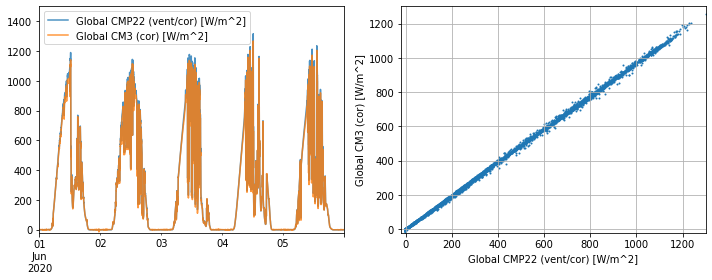

In [4]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(ncols=2, figsize=(10,4))
# plot both measurement as a time-series
data[['Global CMP22 (vent/cor) [W/m^2]', 'Global CM3 (cor) [W/m^2]']].plot(
    ax=axes[0], alpha=0.8, ylim=[-20, 1500])
# compare measurements with a scatter plot
data.plot.scatter(ax=axes[1], s=1, grid=True,
                  x='Global CMP22 (vent/cor) [W/m^2]',
                  y='Global CM3 (cor) [W/m^2]',
                  xlim=[-20, 1300], ylim=[-20, 1300])
fig.tight_layout()

## References

* Adam R. Jensen, Kevin S. Anderson, William F. Holmgren, Mark A. Mikofski, Clifford W. Hansen, Leland J. Boeman, and Roel Loonen. Pvlib iotoolsâ€”open-source python functions for seamless access to solar irradiance data. Solar Energy, 266:112092, 2023. doi: [10.1016/j.solener.2023.112092](https://doi.org/10.1016/j.solener.2023.112092).